# ANSI Application analysis

In [1]:
import numpy
import pandas
import matplotlib.pyplot as plotter
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
def view_boxplot(df):
    %matplotlib
    df.boxplot()
    plotter.show()

In [3]:
def view_plot(df):
    %matplotlib
    df.plot()
    plotter.show()

In [4]:
def view_hist(df):
    for column in df.columns:
        print(column)
        df[column].hist()
        plotter.show()

## CPU data

In [5]:
cpu_df = pandas.read_csv('data/ansi_fake_data/ansi_fake_data_cpu.csv', index_col='Time').drop('Unnamed: 0', axis=1)

In [6]:
#cpu_df.columns

In [7]:
#view_boxplot(cpu_df)

## Network TX

In [8]:
txnet_df = pandas.read_csv('data/ansi_fake_data/ansi_fake_data_network_tx.csv', index_col='Time').drop('Unnamed: 0', axis=1)

In [9]:
#txnet_df.columns

In [10]:
#view_boxplot(txnet_df)

## Network RX

In [11]:
rxnet_df = pandas.read_csv('data/ansi_fake_data/ansi_fake_data_network_rx.csv', index_col='Time').drop('Unnamed: 0', axis=1)

In [12]:
#rxnet_df.columns

In [13]:
rxnet_df = rxnet_df.clip(lower=0, upper=15000)
#view_boxplot(rxnet_df)

## Disk IO data

In [14]:
disk_df = pandas.read_csv('data/ansi_fake_data/ansi_fake_data_disk_io.csv', index_col='Time').drop('Unnamed: 0', axis=1)

In [15]:
#disk_df.columns

In [16]:
disk_df = disk_df.clip(lower=0, upper=4000)
#view_boxplot(disk_df)

## Context switching

In [17]:
context_df = pandas.read_csv('data/ansi_fake_data/ansi_fake_data_context.csv', index_col='Time').drop('Unnamed: 0', axis=1)

In [18]:
#context_df.columns

In [19]:
context_df = context_df.clip(lower=0, upper=5000)
#view_boxplot(context_df)

## Seperate into proper dataframes for each node

In [20]:
dframes = [cpu_df, txnet_df, rxnet_df, context_df, disk_df]
node = {}

for i in range(1,5):
    frames = []
    
    for dframe in dframes:
        columns = list(filter(lambda x: f'bb{i}l' in x, dframe.columns))
        frames.append(dframe[columns])

    node[i] = pandas.concat(frames, join='inner', axis=1).fillna(0)[:38200]

In [21]:
for i in range(1,5):
    print(node[i].shape)
    print(i)
    #view_hist(node[i])
    
print(node[1].columns)

(38200, 29)
1
(38200, 29)
2
(38200, 29)
3
(38200, 29)
4
Index(['cpu_value host bb1localdomain type_instance idle',
       'cpu_value host bb1localdomain type_instance interrupt',
       'cpu_value host bb1localdomain type_instance nice',
       'cpu_value host bb1localdomain type_instance softirq',
       'cpu_value host bb1localdomain type_instance steal',
       'cpu_value host bb1localdomain type_instance system',
       'cpu_value host bb1localdomain type_instance user',
       'cpu_value host bb1localdomain type_instance wait',
       'interface_tx host bb1localdomain instance lo type if_dropped',
       'interface_tx host bb1localdomain instance lo type if_errors',
       'interface_tx host bb1localdomain instance lo type if_octets',
       'interface_tx host bb1localdomain instance lo type if_packets',
       'interface_tx host bb1localdomain instance wlan0 type if_dropped',
       'interface_tx host bb1localdomain instance wlan0 type if_errors',
       'interface_tx host bb1loc

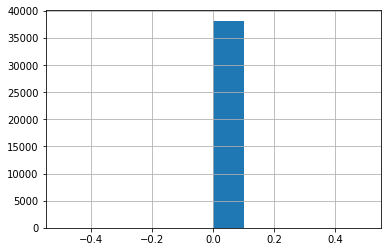

In [22]:
columns = node[1].columns
#%matplotlib
node[1][columns[1]].hist()
plotter.show()

## Get data

In [23]:
data_matrices = []

for i in range(1,5):
    data_matrices.append(node[i].as_matrix())
    
data = numpy.vstack(data_matrices)

In [24]:
data.shape

(152800, 29)

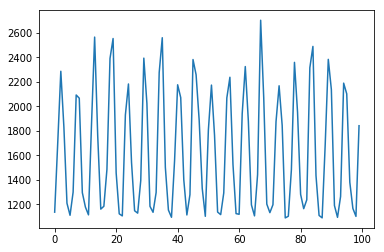

(152800, 29)


In [25]:
tdata = data[:,24]
plotter.plot(tdata.T[:100])
plotter.show()
print(data.shape)

In [26]:
#data = data[:,24]

## Prepare scaler

In [27]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
scaler = MinMaxScaler()
pca = PCA(n_components=1)

In [28]:
scaler.fit(data)
pca.fit(scaler.transform(data))
del data

---

## Correrlation measurement

---

------

-----

# Prediction

In [29]:
for i in range(len(data_matrices)):
    
    transformed = pca.transform(scaler.transform(data_matrices[i]))
    data_matrices[i] = transformed

X = numpy.hstack(data_matrices[:-1])
print(X.shape)

(38200, 3)


(3, 38200)
Shape of train (3, 34380)
Shape of val (3, 1000)
Shape of test (3, 2820)


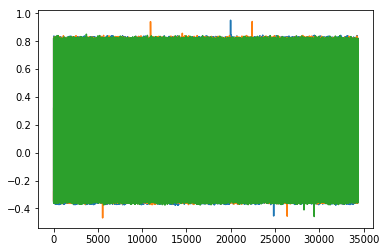

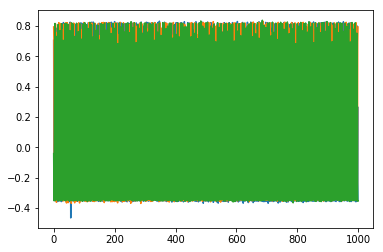

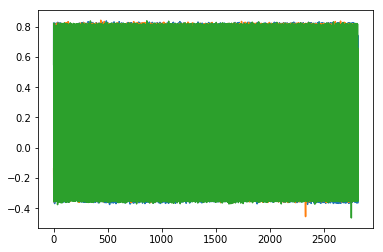

In [30]:
X=X.T
print(X.shape)
LEN = X.shape[1]
SPLIT = int(0.9*LEN)

train_X = X[:,:SPLIT]
val_X = X[:,SPLIT:SPLIT+1000]
test_X = X[:,SPLIT+1000:]

print(f"Shape of train {train_X.shape}")
print(f"Shape of val {val_X.shape}")
print(f"Shape of test {test_X.shape}")

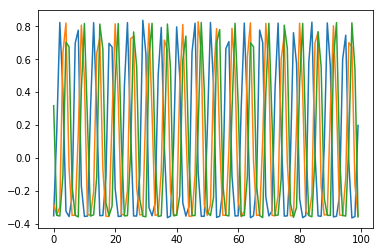

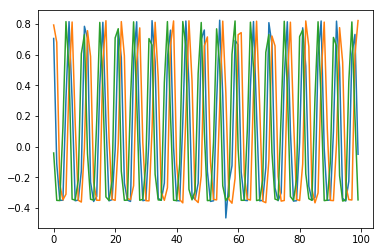

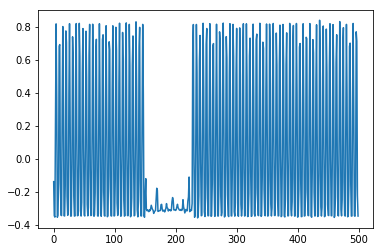

In [38]:
plotter.plot(train_X.T[:100])
plotter.show()
plotter.plot(val_X.T[:100])
plotter.show()
plotter.plot(test_X.T[:500,1])
plotter.show()

In [31]:
def flat_generator(X, tsteps = 5, ravel=1):
    i = 0
    
    while True:
        batch_X = X[:,i:i+tsteps,:]
        batch_y = X[:,i+tsteps,:]
            
        if ravel:
            batch_X = batch_X.reshape((batch_X.shape[0], -1))
        #print(batch_X.shape)
        #print(batch_y.shape)
        
        yield batch_X, batch_y
        
        i += 1
        if i > (X.shape[1] - tsteps - 1):
            i = 0
            continue